In [1]:
import os

#import matplotlib
#matplotlib.use('MACOSX')
#for some reason if I run these 2 lines - it doesnt plot at all any more.


import numpy as np
import mne
import matplotlib.pyplot as plt
from copy import deepcopy
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch


In [2]:
#Load data

#! use relative paths!

kath_raw_file = os.path.join('Katharinas_Data','sub_HT05ND16', '210811', 'mikado-1.fif')                               
raw = mne.io.read_raw_fif(kath_raw_file)

Opening raw data file Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Katharinas_Data/sub_HT05ND16/210811/mikado-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.

/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_37980/519485196.py:6: RuntimeWarning: This filename (Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(kath_raw_file)


    Range : 3376000 ... 4942999 =   3376.000 ...  4942.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Katharinas_Data/sub_HT05ND16/210811/mikado-3.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 4943000 ... 5198999 =   4943.000 ...  5198.999 secs
Ready.


In [3]:
def make_folders_meg(sid='1'):
#Create folders (if they dont exist yet)

#sid is subject Id, must be a string.
#Folders are created in BIDS-compliant directory order: 
#Working directory - Subject - derivtaives - megQC - csvs and figures

    #This is the list of folders and subfolders to be created. Loop checks if directory already exists, if not - create.
    #Make sure to add subfolders on the list here AFTER the parent folder.

    #DO WE NEED TO CREATE IT ACTUALLY NOT IN CURRENT DIRECTORY, BUT GO ONE STEP UP FROM CURRENT DIRECTORY AND THEN CREAT DERIVATIVES?

    path_list = [f'./derivatives', 
    f'./derivatives/sub-{sid}',
    f'./derivatives/sub-{sid}/megqc',
    f'./derivatives/sub-{sid}/megqc/csv files',
    f'./derivatives/sub-{sid}/megqc/figures']

    print(path_list)

    for path in path_list:
        if os.path.isdir(path)==False: #if directory doesnt exist yet - create
            os.mkdir(path)

In [4]:
make_folders_meg(sid='1')

['./derivatives', './derivatives/sub-1', './derivatives/sub-1/megqc', './derivatives/sub-1/megqc/csv files', './derivatives/sub-1/megqc/figures']


In [7]:
#crop the data to calculate faster

raw_cropped = raw.copy()
raw_cropped.crop(0, 300) #(first 5 min)

<Raw | mikado-1.fif, 319 x 300001 (300.0 s), ~6.6 MB, data not loaded>

In [8]:
#Filter the data

def filtering_data(data=None,l_freq=None, h_freq=None, method='iir'):
    # Filtering the data. Recommended: 1-100Hz bandpass or 0.5-100 Hz - better for frequency spectrum
    # https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.filter

    # method='iir' - I m using here the Butterworth filter similar to filtfilt in matlab, like we  
    # did in the course with eeg data. such filter creates no time shift, since it filters forward and backward.
    # But we might use a different filter as well. I dont know if this one is the best possible option.

    #Data has to be loaded into mememory before filetering:
    data.load_data(verbose=True)
    raw_bandpass = data.copy()
    raw_bandpass.filter(l_freq=l_freq, h_freq=h_freq, picks='meg', method=method, iir_params=None)

    return(raw_bandpass)


In [9]:
#apply filtgering

filtered_d=filtering_data(data=raw_cropped,l_freq=0.5, h_freq=100, method='iir')

Reading 0 ... 300000  =      0.000 ...   300.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 100.00 Hz: -6.02, -6.02 dB



In [10]:

def Epoch_meg(data=None, stim_channel='STI101', event_dur=1.2, mags_grads_separate=True, epoch_tmin=-0.2, epoch_tmax=1):

       #2 OPTIONS TO RETURN DATA FRAME OF EPOCHS: MAGS+GRADS IN ONE DF OR SEPARATE. CAN MAKE ONLY SEPARATE OPTION AND 
       # REWRITE CODE SO THAT WE USE DFS SEPARATE. IF WE NEVER NEED MAGS AND GRADS TOGETEHR. CHECK THAT!

       #mags_grads_separate: 0 - everything in one object and data frame, 1 - mags and grads separate.


       picks_grad = mne.pick_types(data.info, meg='grad', eeg=False, eog=False, stim=False)
       picks_magn = mne.pick_types(data.info, meg='mag', eeg=False, eog=False, stim=False)

       events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)
       n_events=len(events)

       if mags_grads_separate==True:
              epochs_mags = mne.Epochs(data, events, picks=picks_magn, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None)
              epochs_grads = mne.Epochs(data, events, picks=picks_grad, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None)

              #Present epochs as data frame - separately for mags and grads
              df_epochs_mags = epochs_mags.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))
              df_epochs_grads = epochs_grads.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))

              return(n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads)
              #Returns: 
              # number of events(=number of epochs), 
              # data frame containing data for all epochs: mags and grads separately
              # epochs as mne data structure (not used anywhere, we may use it for something in the future)

       elif mags_grads_separate==False:
              #Find events and epochs:

              epochs = mne.Epochs(data, events, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None) #, event_id=event_dict, reject=reject_criteria)

              #Present epochs as data frame:
              df_epochs_all = epochs.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))

              return(n_events, df_epochs_all, epochs)

              #Returns: 
              # number of events(=number of epochs), 
              # data frame containing data for all epochs and all channels together, 
              # epochs as mne data structure (not used anywhere, we may use it for something in the future)
       else:
              print('Parameter "mags_grads_separate" must be set to True or False')
              return



In [11]:
#Apply epoching:
#Left it as a function. But the plan is to amke it an oblogatory step. So that teh user doesnt have to input 
# different epoch parameters in difefrent fucbtions and all calculation goes for the same epochs (RMSE, freq. spectrum):

#epochs for mags and grads separately
n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads=Epoch_meg(data=filtered_d, stim_channel='STI101', event_dur=1.2, mags_grads_separate=1, epoch_tmin=-0.2, epoch_tmax=1)

#epochs for them together in one object:
n_events, df_epochs_all, epochs=Epoch_meg(data=filtered_d, stim_channel='STI101', event_dur=1.2, mags_grads_separate=0, epoch_tmin=-0.2, epoch_tmax=1)

#df_epochs_mags

Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
8 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_37980/28012379.py:12: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)


Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
8 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_37980/28012379.py:12: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)


In [12]:
#%% RMSE - general function to use in other functions
#STD CALCULATION IS MUCH LESS COdE BUT TAKES LONGER THAN RMSE

def RMSE(data_mags=None, data_grads=None):

    # https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python

    from sklearn.metrics import mean_squared_error

    #Magnitometers:
    y_actual_mags=data_mags #refrence to data_mags
    y_predicted_mags=data_mags.mean(axis=1)

    rmse_mags = np.zeros(len(y_predicted_mags)) #RMSE of all magnetometers

    for i in range(len(y_predicted_mags)):
        y_predicted_vec_mags=np.ones(len(y_actual_mags[0]))*y_predicted_mags[i]
        rmse_mags[i] = mean_squared_error(y_actual_mags[i, :], y_predicted_vec_mags, squared=False)


    #Gradiometers:
    y_actual_grads=data_grads #refrence to data_grads
    y_predicted_grads=data_grads.mean(axis=1)

    rmse_grads = np.zeros(len(y_predicted_grads)) #RMSE of all gradiometers

    for i in range(len(y_predicted_grads)):
        y_predicted_vec_grads=np.ones(len(y_actual_grads[0]))*y_predicted_grads[i]
        rmse_grads[i] = mean_squared_error(y_actual_grads[i, :], y_predicted_vec_grads, squared=False)

    return(rmse_mags, rmse_grads)


In [13]:
# Root mean squared error calculation (or STD - same result) over all data:

def RMSE_meg_all(data=None, std_lvl=1, plotflag=True, sid='1'): #, min_duration_event=1, epoch_tmin=-0.2, epoch_tmax=1):
    #give path to directory and then it should auto find the data file when bids compliant.
    ##maybe distinguish between negative and positive std_lvl

    #plotflag - plot or no plot
    #sid - subject Id. Has to be a string , like '1'

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]
  

    # Separate data for mags and grads in 2 arrays.
    selected_mags = [item[1] for item in mags]
    selected_grads = [item[1] for item in grads]
    data_mags, times = data[selected_mags, :]  
    data_grads, times = data[selected_grads, :]  

    # %% Calculate STD or RMSE of each channel

    #Calculate RMSE for each channel (separated mags and grads) - for the entire time duration:
    std_mags, std_grads = RMSE(data_mags=data_mags, data_grads=data_grads)

    #STD (if wanna use insted of RMSE. it will exactly replace the RMSE function above):
    #std_mags=np.std(data_mags, axis=1) #calculate std of all magnetometers (along second dimantion)
    #std_grads=np.std(data_grads, axis=1) #calculate std of all gradiometers (along second dimantion)


    # Check if channel data is within 1 std over all channels.
    # COMMENT: can use -3 to 3 (or other number) std istead of -1/+1 std, but this can adjusted later. 
    # 1 std is too narrow, gives way too many bad channels.

    std_std_mags=np.std(std_mags)
    std_std_grads=np.std(std_grads)

    mean_std_mags=np.mean(std_mags)
    mean_std_grads=np.mean(std_grads)

    ch_large_std_mags= np.where(std_mags > mean_std_mags+std_lvl*std_std_mags) # | std_mags < mean_std_magn-std_std_mags)
    ch_large_std_grads= np.where(std_grads > mean_std_grads+std_lvl*std_std_grads) # | std_grads < mean_std_grad-std_std_grads)

    ch_small_std_mags= np.where(std_mags < mean_std_mags-std_lvl*std_std_mags)
    ch_small_std_grads= np.where(std_grads < mean_std_grads-std_lvl*std_std_grads)


    magn_channel_big_std=np.array(mags)[ch_large_std_mags[0]]
    grad_channel_big_std=np.array(grads)[ch_large_std_grads[0]]

    magn_channel_small_std=np.array(mags)[ch_small_std_mags[0]]
    grad_channel_small_std=np.array(grads)[ch_small_std_grads[0]]

    print('Magnetometers with high STD: ', magn_channel_big_std)
    print('Gradiometers with high STD: ',grad_channel_big_std)

    print('Magnetometers with low STD: ', magn_channel_small_std)
    print('Gradiometers with low STD: ',grad_channel_small_std)


    if plotflag==True:
        
        from matplotlib import pyplot as plt
        #%matplotlib qt
        #%matplotlib inline

        fig, (ax1, ax2) = plt.subplots(2)
        fig.suptitle('STDs')
        ax1.plot(list(range(1, len(std_mags)+1)), std_mags)
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags]*len(std_mags))
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags-std_lvl*std_std_mags]*len(std_mags))
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags+std_lvl*std_std_mags]*len(std_mags))
        ax1.set(xlabel='Magnetometer', ylabel='STD')

        ax2.plot(list(range(1, len(std_grads)+1)), std_grads)
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads]*len(std_grads))
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads-std_lvl*std_std_grads]*len(std_grads))
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads+std_lvl*std_std_grads]*len(std_grads))
        ax2.set(xlabel='Gradiometer', ylabel='STD')

        plt.savefig('./derivatives/sub-'+sid+'/megqc/figures/RMSE_all_channels.png')


    #Return the channel names with STD over the set STD level and under the set negative STD level.
    return(magn_channel_big_std, grad_channel_big_std, magn_channel_small_std, grad_channel_small_std)


    #CAN ADD OPTIONAL PLOTTING OF SOME CHANNELS WITH HIGH/LOW STD. DO WE NEED THAT?
    #WHAT DO WE WANT TO GIVE AS OUTPUT HERE? NEED PLOTS, NEED LIST OF CHANNELS?

Magnetometers with high STD:  [['MEG0621' '74']
 ['MEG1021' '116']
 ['MEG1031' '119']
 ['MEG1041' '122']
 ['MEG1421' '164']
 ['MEG1431' '167']
 ['MEG1741' '206']
 ['MEG2121' '248']
 ['MEG2131' '251']
 ['MEG2141' '254']
 ['MEG2331' '275']
 ['MEG2531' '299']
 ['MEG2541' '302']
 ['MEG2621' '308']
 ['MEG2631' '311']]
Gradiometers with high STD:  [['MEG1023' '118']
 ['MEG1323' '154']
 ['MEG1412' '162']
 ['MEG1442' '171']
 ['MEG1713' '199']
 ['MEG1742' '207']
 ['MEG1743' '208']
 ['MEG1813' '211']
 ['MEG1922' '225']
 ['MEG1923' '226']
 ['MEG1932' '228']
 ['MEG1933' '229']
 ['MEG2112' '246']
 ['MEG2113' '247']
 ['MEG2122' '249']
 ['MEG2123' '250']
 ['MEG2132' '252']
 ['MEG2133' '253']
 ['MEG2142' '255']
 ['MEG2143' '256']
 ['MEG2323' '274']
 ['MEG2332' '276']
 ['MEG2333' '277']
 ['MEG2342' '279']
 ['MEG2512' '294']
 ['MEG2513' '295']
 ['MEG2522' '297']
 ['MEG2533' '301']
 ['MEG2542' '303']
 ['MEG2543' '304']
 ['MEG2612' '306']
 ['MEG2613' '307']
 ['MEG2623' '310']
 ['MEG2633' '313']]
Magnetome

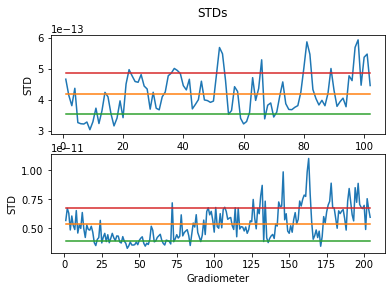

In [14]:
#Try:

magn_channel_big_std, grad_channel_big_std, magn_channel_small_std, grad_channel_small_std=RMSE_meg_all(data=filtered_d, std_lvl=1, plotflag=True, sid='1')

In [15]:
# STD over epochs. 
def RMSE_meg_epoch(data=None, std_lvl=1, n_events=n_events, df_epochs_all=df_epochs_all, sid='1'):

#def RMSE_meg_epoch(data=None, std_lvl=1, stim_channel='STI101',  min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1):
    #stim_channel name is users input. but we can also let mne find it itself if 'None' is set? mne seems to have such function.

    # 1) Loop over the epochs of each channel and check for every separate magn and grad and calculate std
    import pandas as pd
    eps=list(range(0,n_events)) #list of epoch numbers

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]
    
    mags_names = [mag[0] for mag in mags]
    grads_names = [grad[0] for grad in grads]

    combined_names = {"mags": mags_names, "grads": grads_names}

    dict_mags = {}
    dict_grads = {}

    for ep in eps: #loop over each epoch
        rows_for_ep = [row for row in df_epochs_all.iloc if row.epoch == ep]

        std_epoch = {"mags": [], "grads": []}

        for key_of_list in combined_names: #loop over mags, then grads

            for ch_name in combined_names[key_of_list]: #loop over channel names
                
                data_ch_epoch = [row_m[ch_name] for row_m in rows_for_ep]

                std_ch_ep = np.std(data_ch_epoch)   #HERE CAN ALSO REPLACE STD WITH RMSE CALCULATION FOR SPEED!

                std_epoch[key_of_list].append(std_ch_ep)

        dict_mags[ep] = std_epoch["mags"]
        dict_grads[ep] = std_epoch["grads"]

    df_std_mags = pd.DataFrame(dict_mags, index=mags_names)
    df_std_grads = pd.DataFrame(dict_grads, index=grads_names)

    # 2) Check (which epochs for which channel) are over 1STD (or 2, 3, ets STDs) for (this epoch for all channels)

    #Find what is 1 std over all channels per 1 epoch:
    std_std_mags_per_epoch=[]
    std_std_grads_per_epoch=[]
    mean_std_mags_per_epoch=[]
    mean_std_grads_per_epoch=[]

    for ep in eps: #goes over each epoch
        std_std_mags_per_epoch.append(np.std(df_std_mags.iloc[:, ep])) #std of stds of all channels of every single epoch
        std_std_grads_per_epoch.append(np.std(df_std_grads.iloc[:, ep]))

        mean_std_mags_per_epoch.append(np.mean(df_std_mags.iloc[:, ep])) #mean of stds of all channels of every single epoch
        mean_std_grads_per_epoch.append(np.mean(df_std_grads.iloc[:, ep]))


    df_ch_ep_large_std_mags=df_std_mags.copy()
    df_ch_ep_large_std_grads=df_std_grads.copy()

    df_ch_ep_small_std_mags=df_std_mags.copy()
    df_ch_ep_small_std_grads=df_std_grads.copy()

    #Now see which channles in epoch are over 1 std or under -1 std:
    for ep in eps: #goes over each epoch   
        df_ch_ep_large_std_mags.iloc[:,ep] = df_ch_ep_large_std_mags.iloc[:,ep] > mean_std_mags_per_epoch[ep]+std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_large_std_grads.iloc[:,ep] = df_ch_ep_large_std_grads.iloc[:,ep] > mean_std_grads_per_epoch[ep]+std_lvl*std_std_grads_per_epoch[ep] #gradiometers

        df_ch_ep_small_std_mags.iloc[:,ep] = df_ch_ep_small_std_mags.iloc[:,ep] < mean_std_mags_per_epoch[ep]-std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_small_std_grads.iloc[:,ep] = df_ch_ep_small_std_grads.iloc[:,ep] < mean_std_grads_per_epoch[ep]-std_lvl*std_std_grads_per_epoch[ep] #gradiometers


    # Create csv files  for the user:

    df_std_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/std_mags_per_epoch.csv')
    
    df_std_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/std_grads_per_epoch.csv')

    df_ch_ep_large_std_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/Large_std_mags_per_epoch.csv')

    df_ch_ep_large_std_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/Large_std_grads_per_epoch.csv')

    df_ch_ep_small_std_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/Small_std_mags_per_epoch.csv')

    df_ch_ep_small_std_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/Small_std_grads_per_epoch.csv')

 

In [16]:
#try (will output csv files):
RMSE_meg_epoch(data=filtered_d, std_lvl=1, sid='1') #stim_channel='STI101', std_lvl=1, min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1)

In [17]:
#Calculate frequency spectrum:
#UPD: as discussed with Jochem, only calculate over whole time, no over concatenated epochs. For concatenated version see Funks_old notebook.

def Freq_Spectrum_meg(data=None, df_epochs_mags=df_epochs_mags, df_epochs_grads=df_epochs_grads, plotflag=True, sid='1', freq_min=1, 
    freq_max=200, n_fft=1000, n_per_seg=1000, freq_tmin=None, freq_tmax=None):

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]

    # Frequency spectrum using Welch method OVER ALL TIME. USING MNE:

    picks_grad = mne.pick_types(data.info, meg='grad', eeg=False, eog=False, stim=False)
    picks_magn = mne.pick_types(data.info, meg='mag', eeg=False, eog=False, stim=False)

    psds_mags, freqs_mags = psd_welch(data, fmin=freq_min, fmax=freq_max, n_jobs=-1, picks=picks_magn, n_fft=n_fft, n_per_seg=n_per_seg, tmin=freq_tmin, tmax=freq_tmax)
    psds_grads, freqs_grads = psd_welch(data, fmin=freq_min, fmax=freq_max, n_jobs=-1, picks=picks_grad, n_fft=n_fft, n_per_seg=n_per_seg, tmin=freq_tmin, tmax=freq_tmax)
    #CALCULATES NOW OVER ALL TIME. SET TIME HERE IF WANT IT FASTER OR PARTICULAR PERIOD. RESULT CAN LOOK VERY DIFFERNT.

    # n_per_seg - Length of each Welch segment (windowed with a Hamming window). Defaults to None, which sets n_per_seg equal to n_fft.
    # n_fft - The length of FFT used, must be >= n_per_seg (default: 256). The segments will be zero-padded if n_fft > n_per_seg. If n_per_seg 
    # is None, n_fft must be <= number of time points in the data.
    # These influence the bandwidth.

    #Plot the result over all time:

    freqs_mat_mags=np.tile(freqs_mags, [np.shape(psds_mags)[0],1])
    freqs_mat_grads=np.tile(freqs_grads, [np.shape(psds_grads)[0],1])

    
    if plotflag==True:
        from matplotlib import pyplot as plt

        %matplotlib qt
        #%matplotlib inline

        #Magnetometers:
        plt.figure()
        plt.plot(freqs_mat_mags.T, np.sqrt(psds_mags.T))
        plt.yscale='log'
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power spectral density (T / Hz)')  #check the units!
        plt.title("Welch's periodogram for all magnetometers")
        plt.savefig('./derivatives/sub-'+sid+'/megqc/figures/PSD_over_all_data_mags.png')
        #plt.show()
        
        #Freq spectrum peaks we see (visible on shorter interval, ALMOST NONE SEEN when Welch is done over all time):
        #50, 100, 150 - powerline EU
        #6 noise of shielding chambers 
        #44 meg noise
        #17 - was it the train station near by?
        #10 Secret :)
        #1hz - highpass filter.
        #flat spectrum is white noise process. Has same energy in every frequency (starts around 50Hz or even below)

        #Gradiometers:
        plt.figure()
        plt.plot(freqs_mat_grads.T, np.sqrt(psds_grads.T))
        plt.yscale='log'
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power spectral density (T/m)²/Hz)')  #check the units!
        plt.title("Welch's periodogram for all gradiometers")
        plt.savefig('./derivatives/sub-'+sid+'/megqc/figures/PSD_over_all_data_grads.png')
        #plt.show()

        #Need to find frequencies.. and filter out? 
        #Powerline
        #Eye moves 
        #Blinks
        #Cardio: try to autocreate it. Maybe it s small enough to not care?
        #Muscle movements 

    return(mags, grads, freqs_mags, freqs_grads, psds_mags, psds_grads) 
    #mags, grads are channels (name, index)

In [18]:
#try:
mags, grads, freqs_mags, freqs_grads, psds_mags, psds_grads = Freq_Spectrum_meg(data=filtered_d, plotflag=True, sid='1', freq_min=0.5, freq_max=100, 
    n_fft=1000, n_per_seg=1000, freq_tmin=None, freq_tmax=None)

Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    8.8s remaining:   14.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    8.8s remaining:    5.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.8s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


In [23]:

def Power_of_freq_meg(mags=mags, grads=grads, freqs_mags=freqs_mags, freqs_grads=freqs_grads, psds_mags=psds_mags, psds_grads=psds_grads, mean_power_per_band=True, plotflag=True, sid='1'):

    # Power of frequencies calculation for all mags + grads channels separately, 
    # saving power + power/freq value in data frames.

    from scipy.integrate import simps
    import pandas as pd

    # adopted from: https://raphaelvallat.com/bandpower.html
    
    # Calculate the band power:
    wave_bands=[[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
    #delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (12–30 Hz), and gamma (30–100 Hz) bands

    mags_names = [mag[0] for mag in mags]
    grads_names = [grad[0] for grad in grads]

    dict_mags_power = {}
    dict_grads_power = {}

    dict_mags_power_freq = {}
    dict_grads_power_freq = {}

    dict_mags_rel_power = {}
    dict_grads_rel_power = {}

    for w in enumerate(wave_bands): #loop over bands

        low, high = w[1] # Define delta lower and upper limits
        power_per_band = {"mags": [], "grads": []}
        power_per_freq_per_band = {"mags": [], "grads": []}
        rel_power_per_band = {"mags": [], "grads": []}

    #loop over mags, then grads

        idx_delta_m = np.logical_and(freqs_mags >= low, freqs_mags <= high)
        for m in enumerate(psds_mags): 
        #loop over mags channels. psd_ch_m is psd of partigular channel

            #ch_name_m=mags_names[m[0]]
            psd_ch_m=np.array(m[1])

            #Area under the curve:
            # Frequency resolution
            freq_res = freqs_mags[1] - freqs_mags[0]  # = 1 / 4 = 0.25

            # Compute the absolute power by approximating the area under the curve
            band_power_m = simps(psd_ch_m[idx_delta_m], dx=freq_res)

            #devide the power by the  number of frequencies in the band
            power_compare_m=band_power_m/sum(idx_delta_m) 

            #calculate the relative power: % of this band in the total bands power for this channel:
            total_power_m = simps(psd_ch_m, dx=freq_res)
            band_rel_power_m = band_power_m / total_power_m

            power_per_band['mags'].append(band_power_m)
            rel_power_per_band['mags'].append(band_rel_power_m)
            power_per_freq_per_band['mags'].append(power_compare_m)

        #print('mags done')

        idx_delta_g = np.logical_and(freqs_grads >= low, freqs_grads <= high)
        for g in enumerate(psds_grads): 
        #loop over grads channels and their names

            #ch_name_g=grads_names[g[0]]
            psd_ch_g=np.array(g[1])

            #Area under the curve:
            # Frequency resolution
            freq_res = freqs_grads[1] - freqs_grads[0]  

            # Compute the absolute power by approximating the area under the curve
            band_power_g = simps(psd_ch_g[idx_delta_g], dx=freq_res)

            #devide the power by the  number of frequencies in the band
            power_compare_g=band_power_g/sum(idx_delta_g) 

            #calculate the relative power: % of this band in the total bands power for this channel:
            total_power_g = simps(psd_ch_g, dx=freq_res)
            band_rel_power_g = band_power_g / total_power_g

            power_per_band['grads'].append(band_power_g)
            rel_power_per_band['grads'].append(band_rel_power_g)
            power_per_freq_per_band['grads'].append(power_compare_g)


            
        dict_mags_power[w[0]] = power_per_band["mags"]
        dict_grads_power[w[0]] = power_per_band["grads"]

        dict_mags_power_freq[w[0]] = power_per_freq_per_band["mags"]
        dict_grads_power_freq[w[0]] = power_per_freq_per_band["grads"]

        dict_mags_rel_power[w[0]] = rel_power_per_band["mags"]
        dict_grads_rel_power[w[0]] = rel_power_per_band["grads"]


    # Save power and delta_compare to data frame:
    df_power_mags = pd.DataFrame(dict_mags_power, index=mags_names)
    df_power_grads = pd.DataFrame(dict_grads_power, index=grads_names)

    df_power_freq_mags = pd.DataFrame(dict_mags_power_freq, index=mags_names)
    df_power_freq_grads = pd.DataFrame(dict_grads_power_freq, index=grads_names)

    df_rel_power_mags = pd.DataFrame(dict_mags_rel_power, index=mags_names)
    df_rel_power_grads = pd.DataFrame(dict_grads_rel_power, index=grads_names)

    # Rename columns and extract to csv:

    renamed_df_power_mags = df_power_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
    renamed_df_power_grads = df_power_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})

    renamed_df_power_freq_mags = df_power_freq_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
    renamed_df_power_freq_grads = df_power_freq_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})

    renamed_df_rel_power_mags = df_rel_power_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
    renamed_df_rel_power_grads = df_rel_power_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})


    # Create csv file  for the user:
   
    renamed_df_power_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/abs_power_mags.csv')

    renamed_df_power_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/abs_power_grads.csv')

    renamed_df_power_freq_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/power_per_freq_mags.csv')

    renamed_df_power_freq_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/power_per_freq_grads.csv')

    renamed_df_rel_power_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/relative_power_mags.csv')

    renamed_df_rel_power_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/relative_power_grads.csv')


    if mean_power_per_band==True: #if user wants to see average power per band over all channels - calculate and plot here:

        #Calculate power per band over all mags and all grads

        import statistics 

        power_dfs=[df_power_mags, df_rel_power_mags, df_power_grads, df_rel_power_grads, df_power_freq_mags, df_power_freq_grads]
        #keep them in this order!  important for this cell calculations

        bands_names=['delta', 'theta', 'alpha', 'beta', 'gamma']
        band_title=['Magnetometers. Average absolute power per band:', 'Magnetometers. Average relative power per band:',
        'Gradiometers. Average absolute power per band:', 'Gradiometers. Average relative power per band:', 
        'Magnetometers. Average power/freq per band:', 'Gradiometers. Average power/freq per band:']

        mean_abs_m=[]
        mean_abs_g=[]
        mean_relative_m=[]
        mean_relative_g=[]
        mean_power_nfreq_m=[]
        mean_power_nfreq_g=[]

        for d in enumerate(power_dfs):
            print(band_title[d[0]])

            for w in enumerate(bands_names): #loop over bands
                mean_power_per_band = statistics.mean(d[1].loc[:,w[0]])
                
                if d[0]==0: #df_power_mags:
                    mean_abs_m.append(mean_power_per_band) 
                elif d[0]==1: #df_rel_power_mags:
                    mean_relative_m.append(mean_power_per_band) 
                elif d[0]==2: #df_power_grads:
                    mean_abs_g.append(mean_power_per_band)
                elif d[0]==3: #df_rel_power_grads:
                    mean_relative_g.append(mean_power_per_band) 
                elif d[0]==4: #df_power_freq_mags:
                    mean_power_nfreq_m.append(mean_power_per_band)
                elif d[0]==5: #df_power_freq_grads:
                    mean_power_nfreq_g.append(mean_power_per_band)
                print(w[1], mean_power_per_band)


        if plotflag==True:

            #Visual: band power over all mags and grads as a pie chart:
            #The mean relative percentages dont sum up into 100%, so added the 'unknown' part.

            bands_names_un_m=['delta', 'theta', 'alpha', 'beta', 'gamma']
            bands_names_un_g=['delta', 'theta', 'alpha', 'beta', 'gamma']

            mean_relative_m_un=[v * 100 for v in mean_relative_m]  #in percentage
            power_unknown_m=100-(sum(mean_relative_m))*100
            if power_unknown_m>0:
                mean_relative_m_un.append(power_unknown_m)
                bands_names_un_m=['delta', 'theta', 'alpha', 'beta', 'gamma', 'unknown']

            mean_relative_g_un=[v * 100 for v in mean_relative_g] #in percentage
            power_unknown_g=100-(sum(mean_relative_g))*100
            if power_unknown_g>0:
                mean_relative_g_un.append(power_unknown_g)
                bands_names_un_g=['delta', 'theta', 'alpha', 'beta', 'gamma', 'unknown']

            fig1, axs = plt.subplots(1,2)
            fig1.suptitle('Relative power of each band')
            axs[0].pie(mean_relative_m_un, labels=bands_names_un_m, autopct='%1.1f%%') #autopct for percentage values
            axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            axs[0].set_title('Magnetometers')
            axs[1].pie(mean_relative_g_un, labels=bands_names_un_g, autopct='%1.1f%%')
            axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            axs[1].set_title('Gradiometers')
            plt.savefig('./derivatives/sub-'+sid+'/megqc/figures/Relative_power_per_band_over_all_channels.png')
            plt.show()


    #Note on the pie chart: it calculates average relative power of each band. Powers might average so, that their sum is over 100% (101,102..). 
    #This is why in pie chart the relative values dont correspond exactly to the relative values which are printed. 
    # (pie recalculates everything so it s 100% in sum).
    #also - there might be the "unknown" frequency and might not. This is why the if statements above.
    #DO WE NEED THE PIE CHART IF IT WORK THIS WAY? MIGHT BE CONFUSING? OR SHOULD WE SKIP CALCULATING AVERAGE POWERS AT ALL?
   
   
    # DECIDE WHAT TO OUTPUT HERE!
    #ask Jochem about reference values for relative power values!


In [25]:
#try:

Power_of_freq_meg(mags=mags, grads=grads, freqs_mags=freqs_mags, freqs_grads=freqs_grads, psds_mags=psds_mags, psds_grads=psds_grads, mean_power_per_band=True, plotflag=True, sid='1')
#will output dataframes

Magnetometers. Average absolute power per band:
delta 4.8890598008351713e-26
theta 2.532641811858604e-26
alpha 1.7403091352657378e-26
beta 5.866221612040931e-26
gamma 1.1364196779340845e-26
Magnetometers. Average relative power per band:
delta 0.31162401778732135
theta 0.1621829253393267
alpha 0.11479478520626317
beta 0.3598652145887459
gamma 0.07105232577736224
Gradiometers. Average absolute power per band:
delta 6.280651970736586e-24
theta 3.2044284397841853e-24
alpha 3.558016522340017e-24
beta 5.7859840670409754e-24
gamma 8.55207636090824e-24
Gradiometers. Average relative power per band:
delta 0.231134576235874
theta 0.1211376909205056
alpha 0.12265496052870091
beta 0.20851152462659395
gamma 0.3172845139996093
Magnetometers. Average power/freq per band:
delta 1.2222649502087928e-26
theta 5.065283623717208e-27
alpha 3.480618270531476e-27
beta 3.0874850589689112e-27
gamma 1.6005910956818092e-28
Gradiometers. Average power/freq per band:
delta 1.5701629926841465e-24
theta 6.4088568795